# Reconstruction from interpolated values with known locations

This notebook illustrates reconstruction using a simple forward model: the interpolation of a volume at a number of points on or off the grid, inside or outside of the range of the grid (to check that the interpolation wraps around). 

The inverse problem is solved using Gradient Descent and Conjugate Gradient.

In [1]:
import jax
import jax.numpy as jnp
from jax import config
import numpy as np
from matplotlib import pyplot as plt

from simplecryoem.forwardmodel import interpolate
from simplecryoem.optimization import conjugate_gradient
from simplecryoem.utils import mip_z

2024-10-11 00:39:27.729801: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create the grids and the volume

In [3]:
nx = 5

x_freq = jnp.fft.fftfreq(nx, 1 / nx)
X, Y, Z = jnp.meshgrid(x_freq, x_freq, x_freq)

x_grid = np.array([x_freq[1], len(x_freq)])

vol = (
    jnp.array(np.random.randn(nx, nx, nx))
    + jnp.array(np.random.randn(nx, nx, nx)) * 1j
    + 100
    + 80j
)

all_coords = jnp.array([X.ravel(), Y.ravel(), Z.ravel()])

### Points to interpolate at

In [4]:
N = 2000

# The points will be between low and high.

# Within the Fourier grid range
# low = -nx/2
# high = nx/2 + 1

# Going outside the range to ensure wrap-around works well.
low = -3 * nx
high = 3 * nx

# On the grid
# pts = jnp.array(np.random.randint(low, high, size = (3,N))).astype(jnp.float64)

# And off the grid
pts = 3 * nx * np.random.randn(3, N)

# Print the points
print(f"min(pts) = {jnp.min(pts)}")
print(f"max(pts) = {jnp.max(pts)}")
print(f"x_freq = {x_freq}")

min(pts) = -55.11066571576218
max(pts) = 60.79050840033646
x_freq = [ 0.  1.  2. -2. -1.]


### The forward model: interpolation

In [5]:
@jax.jit
def interpolate_fun(vol):
    return interpolate(pts, x_grid, vol, "tri")

### The interpolated values, i.e. the data. 

When the points above are on the grid, this is the volume.

In [6]:
data = interpolate_fun(vol)

In [7]:
@jax.jit
def loss_fun(v):
    err = interpolate_fun(v) - data
    return 1 / (2 * len(data)) * jnp.sum(jnp.real(jnp.conj(err) * err))


@jax.jit
def loss_fun_grad(v):
    return jax.grad(loss_fun)(v)

In [8]:
print(loss_fun(vol))
print(loss_fun_grad(vol).shape)

0.0
(5, 5, 5)


### Solve the inverse problem

#### SGD

In [9]:
v0 = (
    jnp.array(np.random.randn(nx, nx, nx)) + jnp.array(np.random.randn(nx, nx, nx)) * 1j
)
# v0 = vol + 0.1*np.random.randn(nx,nx,nx)

vk = v0
N_iter = 2000
alpha = 100
for k in range(N_iter):
    vk = vk - alpha * jnp.conj(loss_fun_grad(vk))

    if jnp.mod(k, 100) == 0:
        loss = loss_fun(vk)
        print("iter ", k, ", loss = ", loss)

err = jnp.max(jnp.abs(vk - vol))
print("err =", err)

iter  0 , loss =  319.32842664758084
iter  100 , loss =  2.3211101029115797e-05
iter  200 , loss =  6.202044644498362e-09
iter  300 , loss =  2.0136468560600797e-12
iter  400 , loss =  7.072629796685786e-16
iter  500 , loss =  2.5639867484174764e-19
iter  600 , loss =  9.422200039860808e-23
iter  700 , loss =  3.562298948296146e-26
iter  800 , loss =  7.549840625072007e-28
iter  900 , loss =  7.549840625072007e-28
iter  1000 , loss =  7.549840625072007e-28
iter  1100 , loss =  7.549840625072007e-28
iter  1200 , loss =  7.549840625072007e-28
iter  1300 , loss =  7.549840625072007e-28
iter  1400 , loss =  7.549840625072007e-28
iter  1500 , loss =  7.549840625072007e-28
iter  1600 , loss =  7.549840625072007e-28
iter  1700 , loss =  7.549840625072007e-28
iter  1800 , loss =  7.549840625072007e-28
iter  1900 , loss =  7.549840625072007e-28
err = 3.5184423277143956e-13


(5, 5, 5)


Text(0.5, 1.0, 'Entry-wise error -- gradient descent')

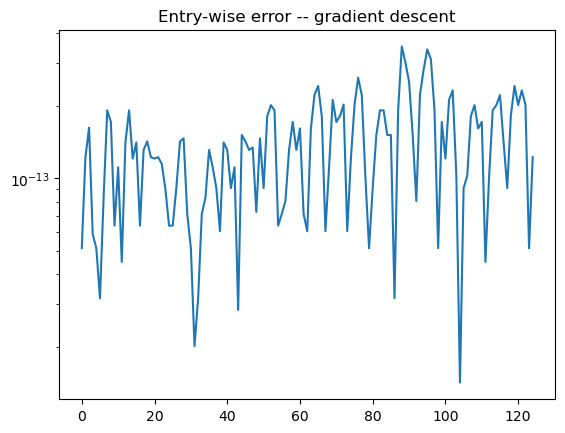

In [10]:
print(vk.shape)
err = vk - vol
plt.semilogy(jnp.abs(err).reshape(-1))
plt.title("Entry-wise error -- gradient descent")

Text(0.5, 1.0, 'Maximum intensity projection of the error')

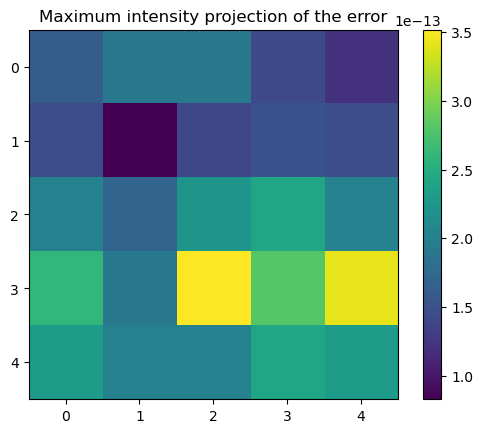

In [11]:
mip_z(jnp.abs(vk - vol))
plt.colorbar()
plt.title("Maximum intensity projection of the error")

#### CG

In [12]:
v0 = (
    jnp.array(np.random.randn(nx, nx, nx)) + jnp.array(np.random.randn(nx, nx, nx)) * 1j
)
zero = jnp.zeros(vol.shape) * 1j
Ab = -jnp.conj(loss_fun_grad(zero))


def AA(a):
    return jnp.conj(loss_fun_grad(a)) + Ab


vcg, max_iter, _ = conjugate_gradient(AA, Ab, v0, 50, verbose=True)
err = jnp.max(jnp.abs(vcg - vol))
print("err =", err)

  cg iter 0 ||r|| = 0.6807456988985352
  cg iter 10 ||r|| = 0.0014072269151343512
  cg iter 20 ||r|| = 9.777334344103117e-06
  cg iter 30 ||r|| = 4.640369381225213e-08
  cg iter 40 ||r|| = 2.1050042269037597e-10
err = 4.669656113096386e-09


Text(0.5, 1.0, 'MIP of the error -- CG')

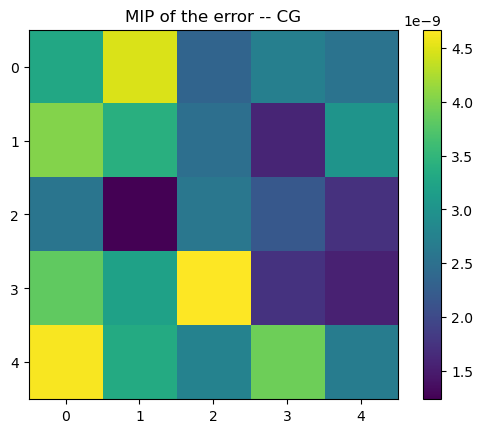

In [13]:
mip_z(jnp.abs(vcg - vol))
plt.colorbar()
plt.title("MIP of the error -- CG")